In [167]:
# run this cell to clean up the variables 
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [7]:
import geopandas as gpd
from shapely.geometry import Polygon
import folium
from os.path import basename, splitext
import pandas as pd
import glob
import os
from pandas import DataFrame
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [8]:
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature  
from matplotlib import pyplot
#import rasterstats
import regionmask
import xarray as xr
#import xesmf as xe
import numpy as np

In [27]:
path = '/Users/carina/Desktop/data/seup/UA_SWE/'

dat = xr.open_dataset(path + '4km_SWE_Depth_WY2016_v01.nc', engine = 'netcdf4') 

In [28]:
#get the OSSE domain area 
US2 = np.array([[-108.565, 40.715], [-105.025, 40.715], [-105.025, 37.525], [-108.565, 37.525]])

names = ["osse_region"]
abbrevs = ["osse"]

osse_region = regionmask.Regions([US2], names=names, abbrevs=abbrevs, name="osse")

osse_region


1 'osse' Regions
osse

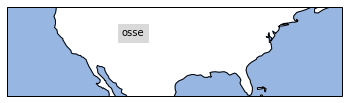

In [29]:
osse_poly = Polygon(US2)
ax = osse_region.plot(label="abbrev")
# fine tune the extent
ax.set_extent([225, 300, 25, 45], crs=ccrs.PlateCarree())
#osse_poly

In [30]:
path_snotel = '/Users/carina/Desktop/data/bcqc_snotel_data/'

def getsnotel_latlon():
    res = pd.DataFrame()
    for file_ in glob.glob("/Users/carina/Desktop/data/bcqc_snotel_data/*.txt"):
        with open(file_) as f:
            textf = " ".join(line.strip() for line in f)
        res = pd.concat([res,pd.DataFrame(data = {"filename" : [splitext(basename(file_))[0]], "stories" : [textf], "bcqc" : [bcqc]})])
    return res

In [47]:
dat.lat.size

621

In [31]:
# Step 1: get a list of all csv files in target directory
my_dir = '/Users/carina/Desktop/data/bcqc_snotel_data/'
filelist = []
filesList = []
os.chdir(my_dir)

# Step 2: Build up list of files
for files in glob.glob("*.txt"):
    fileName, fileExtension = os.path.splitext(files)
    filelist.append(fileName) #filename without extension
    filesList.append(files) #filename with extension

# Step 3: Build up the SNOTEL DataFrame 
df_snotel = DataFrame(filelist ,columns=['File_name'])
df_snotel['Lon'] = df_snotel.File_name.str.split('_').str[2]
df_snotel['Lat'] = df_snotel.File_name.str.split('_').str[1]


In [32]:
df_snotel

,File_name,Lon,Lat
0,bcqc_46.14000_-114.45000,-114.45000,46.14000
1,bcqc_61.75000_-150.89000,-150.89000,61.75000
2,bcqc_48.88000_-121.26000,-121.26000,48.88000
3,bcqc_47.27000_-121.34000,-121.34000,47.27000
4,bcqc_41.49000_-119.00000,-119.00000,41.49000
...,...,...,...
824,bcqc_48.31000_-116.07000,-116.07000,48.31000
825,bcqc_40.79000_-106.60000,-106.60000,40.79000
826,bcqc_43.51000_-115.57000,-115.57000,43.51000
827,bcqc_42.76000_-110.59000,-110.59000,42.76000


In [33]:
def snotel_data(path_snotel):
    parts = path_snotel.split('_')
    lat = parts[3]
    lon = '.'.join(parts[4].split('.')[:-1])
    snotel_obs = pd.read_csv(path_snotel, sep='\s+', header=None)
    snotel_obs.columns = ['year', 'month', 'day', 'daily_P_in', 'Tmax_F', 'Tmin_F', 'Tmean_F','SWE_in'] 
    snotel_obs['Tmean_C'] = (snotel_obs['Tmean_F'] - 32) * (5/9)
    snotel_obs['Lon'] = float(lon)
    snotel_obs['Lat'] = float(lat)
    snotel_obs['Date'] = pd.to_datetime(snotel_obs[['year', 'month', 'day']])
#     snotel_obs = snotel_obs.set_index(pd.DatetimeIndex(pd.to_datetime(snotel_obs[['year', 'month', 'day']])))
#     header_SWE = 'SWE_m_' + lat + '_' + lon
    snotel_obs['SWE_m'] = snotel_obs['SWE_in']*0.0254 #convert to m
    snotel_obs.drop(columns=['year', 'month', 'day', 'daily_P_in', 'Tmax_F', 'Tmin_F', 'Tmean_F', 'SWE_in', 'Tmean_C'], inplace=True)
    snotel_obs.set_index(['Lat', 'Lon', 'Date'], inplace=True)
    return snotel_obs

In [34]:
#path_test = '/Users/carina/Desktop/data/snoho/bcqc_data/bcqc_40.54000_-106.68000_Colorado_Tower.txt'
path_test = '/Users/carina/Desktop/data/bcqc_snotel_data/bcqc_40.43000_-105.73000.txt'
parts = path_test.split('_')
lat = parts[3]
lon = '.'.join(parts[4].split('.')[:-1])
#header_SWE = 'SWE_m_' + lat + lon
#header_SWE 
lon

'-105.73000'

In [35]:
#change type 
df_snotel['Lon'] = df_snotel['Lon'].astype(float)
df_snotel['Lat'] = df_snotel['Lat'].astype(float)


In [36]:
#convert dataframe to point geodataframe 
gdf_snotel = gpd.GeoDataFrame(df_snotel, geometry = gpd.points_from_xy(x = df_snotel.Lon, y = df_snotel.Lat))

In [37]:
df_snotel['File_name'] = filesList

In [199]:
#df_snotel

In [38]:
lat_point_list = [40.715, 40.715, 37.525, 37.525]
lon_point_list = [-108.565, -105.025, -105.025, -108.565]

#polygon_geom = Polygon(zip(lat_point_list, lon_point_list))
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
#polygon_geom = zip(lon_list, lat_list)
crs = {'init': 'epsg:4326'}
gdf_poly = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       

points_within = gpd.sjoin(gdf_snotel, gdf_poly, op = 'within')

#polygon_geom = zip(lon_list, lat_list)


/Users/carina/anaconda3/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


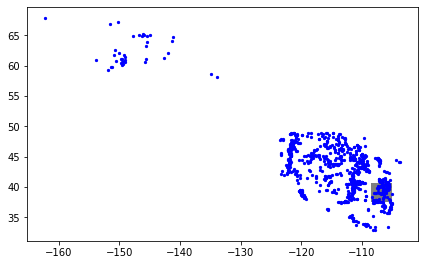

In [39]:
fig, ax = plt.subplots()

gdf_poly.plot(ax=ax, facecolor='gray');


gdf_snotel.plot(ax=ax, color='blue', markersize=5);

plt.tight_layout();

In [40]:
points_within.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 93 entries, 5 to 814
Data columns (total 5 columns):
File_name      93 non-null object
Lon            93 non-null float64
Lat            93 non-null float64
geometry       93 non-null geometry
index_right    93 non-null int64
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 4.4+ KB


In [41]:
points_within_paths = points_within['File_name'].tolist()

for i in range(0, len(points_within_paths)):
    points_within_paths[i] = '/Users/carina/Desktop/data/bcqc_snotel_data/' + points_within_paths[i]

In [42]:
path

'/Users/carina/Desktop/data/seup/UA_SWE/'

In [43]:
dataframes = dict()
for path in points_within_paths:
    #snotel_data = snotel_data(path)
    dataframes[path] = snotel_data(path)

In [44]:
keys = list(dataframes.keys())

li = []

for key in keys:
    li.append(dataframes[key])
    
frame = pd.concat(li, axis=0)
frame.sort_index(inplace=True)
frame.head()

SWE_m
Lat   Lon     Date             
37.61 -105.37 2000-08-15    NaN
              2000-08-16    NaN
              2000-08-17    NaN
              2000-08-18    NaN
              2000-08-19    NaN

In [47]:
lon = -105.85000
lat = 40.40000
point_df = frame.xs((lat, lon))
point_df.plot()
point_df.head()

TypeError: Cannot convert input [(40.4, -105.85)] of type <class 'tuple'> to Timestamp

In [48]:
m = folium.Map(
    location = [40.715, -108.565],
    zoom_start = 12,
    tiles = 'Stamen Terrain'
)

folium.GeoJson(osse_poly).add_to(m)
folium.LatLngPopup().add_to(m)
tooltip = 'Click me!'

folium.Marker([37.7500, -107.6900], popup='<i>Molas Lake</i>', tooltip=tooltip).add_to(m)
folium.Marker([40.5400, -106.6900], popup='<b>Tower</b>', tooltip=tooltip).add_to(m)
folium.Marker([38.1600, -106.6000], popup='<b>Cochetopa Pass</b>', tooltip=tooltip).add_to(m)

df_snotel.apply(lambda row:folium.CircleMarker(location=[row["Lat"], 
                                                  row["Lon"]]).add_to(m),
     axis=1)

from folium.features import DivIcon

folium.map.Marker(
    [37.7500, -107.6900],
    popup='<i>Molas Lake</i>', tooltip=tooltip,
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt">Molas Lake</div>',
        )
    ).add_to(m)

folium.map.Marker(
    [40.5400, -106.6900],
    popup='<i>Molas Lake</i>', tooltip=tooltip,
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt">Tower</div>',
        )
    ).add_to(m)

folium.map.Marker(
    [38.1600, -106.6000],
    popup='<i>Molas Lake</i>', tooltip=tooltip,
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt">Cochetopa Pass</div>',
        )
    ).add_to(m)

m

In [28]:
#load and plot SNOTEL data 

path_Tower = '/Users/carina/Desktop/data/seup/Snotel_Colorado/bcqc_40.54000_-106.68000_Colorado_Tower.txt'
path_Molas_Lake = '/Users/carina/Desktop/data/seup/Snotel_Colorado/bcqc_37.75000_-107.69000_Colorado_Molas_Lake.txt'
path_Cochetopa_Pass = '/Users/carina/Desktop/data/seup/Snotel_Colorado/bcqc_38.16000_-106.60000_Colorado_Cochetopa_Pass.txt'

def snotel_data(path_snotel):
    snotel_obs = pd.read_csv(path_snotel, sep='\s+', header=None)
    snotel_obs.columns = ['year', 'month', 'day', 'daily_P_in', 'Tmax_F', 'Tmin_F', 'Tmean_F','SWE_in'] 
    snotel_obs['Tmean_C'] = (snotel_obs['Tmean_F'] - 32) * (5/9)
    snotel_obs = snotel_obs.set_index(pd.DatetimeIndex(pd.to_datetime(snotel_obs[['year', 'month', 'day']])))
    snotel_obs['SWE_m'] = snotel_obs['SWE_in']*0.0254
    return snotel_obs

In [29]:
snotel_Tower = snotel_data(path_Tower)
snotel_Molas_Lake = snotel_data(path_Molas_Lake)
snotel_Cochetopa_Pass = snotel_data(path_Cochetopa_Pass)

NameError: name 'datetime' is not defined

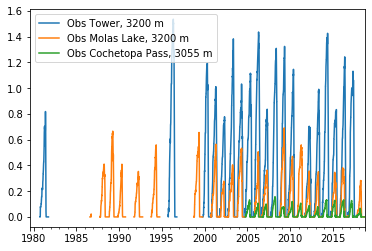

In [31]:
#plot SNOTELS: 
#ax = plt.gca()

ax = snotel_Tower.plot(kind='line',  y = 'SWE_m', label = 'Obs Tower, 3200 m')
snotel_Molas_Lake.plot(kind='line', y = 'SWE_m', label = 'Obs Molas Lake, 3200 m', ax = ax)
snotel_Cochetopa_Pass.plot(kind='line', y = 'SWE_m', label = 'Obs Cochetopa Pass, 3055 m', ax = ax)
ax.set_xlim([datetime(2005, 1, 21), datetime(2017, 12, 1)])
plt.xlabel('Time')
plt.ylabel('SWE [m]')

plt.show()

In [14]:
OSSEregions_poly = regionmask.Regions([osse_poly])
#OSSEregions_poly
mask_OSSE = OSSEregions_poly.mask(dat)

In [15]:
sel_mask = mask_OSSE.where(mask_OSSE == 0).values
sel_mask
lat = mask_OSSE.lat.values
lon = mask_OSSE.lon.values
id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]

In [16]:
out_sel1 = dat.sel(lat = slice(id_lat[0], id_lat[-1]), lon = slice(id_lon[0], 
                                                                    id_lon[-1])).compute().where(mask_OSSE == 0)

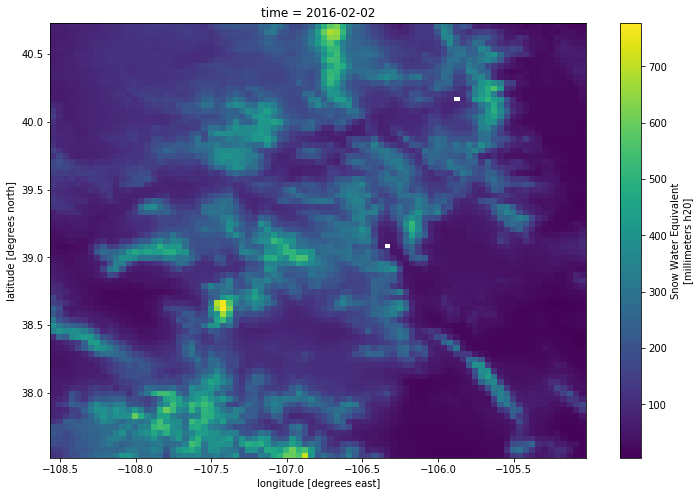

In [18]:
plt.figure(figsize=(12,8))
ax = plt.axes()
out_sel1.SWE.sel(time = '2016-02-02').plot()
#out_sel.mrro.isel(time = 1800).plot(ax = ax)
#basins.plot(ax = ax, alpha = 0.8, facecolor = 'none')